In [ ]:
# Run this if not already installed
!pip install pandas requests opencv-python-headless
!pip install easyocr

In [ ]:
!pip install pytesseract


In [ ]:
# Import necessary libraries
import numpy as np
import pandas as pd
import cv2
import requests
from PIL import Image
from io import BytesIO
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split
import pytesseract
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
import random

# Set random seed for reproducibility
random.seed(42)


In [ ]:
!apt-get install tesseract-ocr -y


Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  tesseract-ocr-eng tesseract-ocr-osd
The following NEW packages will be installed:
  tesseract-ocr tesseract-ocr-eng tesseract-ocr-osd
0 upgraded, 3 newly installed, 0 to remove and 49 not upgraded.
Need to get 4,816 kB of archives.
After this operation, 15.6 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 tesseract-ocr-eng all 1:4.00~git30-7274cfa-1.1 [1,591 kB]
Get:2 http://archive.ubuntu.com/ubuntu jammy/universe amd64 tesseract-ocr-osd all 1:4.00~git30-7274cfa-1.1 [2,990 kB]
Get:3 http://archive.ubuntu.com/ubuntu jammy/universe amd64 tesseract-ocr amd64 4.1.1-2.1build1 [236 kB]
Fetched 4,816 kB in 1s (5,081 kB/s)
Selecting previously unselected package tesseract-ocr-eng.
(Reading database ... 123597 files and directories currently installed.)
Preparing to unpack .../tesseract-ocr-

In [ ]:
import pytesseract
pytesseract.pytesseract.tesseract_cmd = r'/usr/bin/tesseract'


In [ ]:
!pip install tqdm


In [ ]:
import numpy as np
import pandas as pd
import cv2
import requests
from PIL import Image, UnidentifiedImageError
from io import BytesIO
import pytesseract
from tqdm import tqdm

# Load sampletrain.csv data
train_df = pd.read_csv("/content/Book1(1).csv")
test_df = pd.read_csv("/content/Book2test(2).csv")

# Function to download and preprocess image
def load_image_from_url(image_url):
    try:
        response = requests.get(image_url)
        # Check if the response is valid and the content type is an image
        if response.status_code == 200 and 'image' in response.headers['Content-Type']:
            img = Image.open(BytesIO(response.content))
            img = img.resize((128, 128))  # Resizing images to standard size for CNN
            img = np.array(img)
            if img.shape[-1] == 4:  # Handle transparency in PNG
                img = img[..., :3]
            return img / 255.0  # Normalize image
        else:
            print(f"Invalid image URL or non-image content at: {image_url}")
            return np.zeros((128, 128, 3))  # Return a black image as a placeholder
    except UnidentifiedImageError:
        print(f"UnidentifiedImageError for URL: {image_url}")
        return np.zeros((128, 128, 3))  # Return a black image as a placeholder
    except Exception as e:
        print(f"Error downloading image from {image_url}: {e}")
        return np.zeros((128, 128, 3))  # Return a black image as a placeholder

# Function to extract text using OCR
def extract_text_from_image(image_url):
    try:
        response = requests.get(image_url)
        if response.status_code == 200 and 'image' in response.headers['Content-Type']:
            img = Image.open(BytesIO(response.content))
            text = pytesseract.image_to_string(img)
            return text
        else:
            print(f"Invalid image URL or non-image content at: {image_url}")
            return ""  # Return empty string for non-image content
    except UnidentifiedImageError:
        print(f"UnidentifiedImageError for URL: {image_url}")
        return ""  # Return empty string for invalid images
    except Exception as e:
        print(f"Error extracting text from {image_url}: {e}")
        return ""  # Return empty string in case of error

# Apply to the dataset with progress bar
tqdm.pandas()  # Enable progress_apply for pandas

train_df['image_data'] = train_df['image_link'].progress_apply(load_image_from_url)
train_df['ocr_text'] = train_df['image_link'].progress_apply(extract_text_from_image)

test_df['image_data'] = test_df['image_link'].progress_apply(load_image_from_url)
test_df['ocr_text'] = test_df['image_link'].progress_apply(extract_text_from_image)


 52%|█████▏    | 523/999 [00:56<00:50,  9.35it/s]

Invalid image URL or non-image content at: https://m.media-amazon.com/images/I/1yw53vfQtS.jpg


 52%|█████▏    | 521/999 [10:41<08:17,  1.04s/it]

Invalid image URL or non-image content at: https://m.media-amazon.com/images/I/1yw53vfQtS.jpg


100%|██████████| 999/999 [04:52<00:00,  3.41it/s]


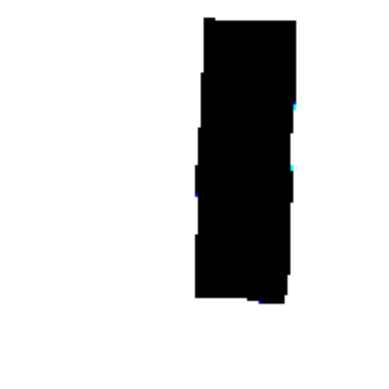

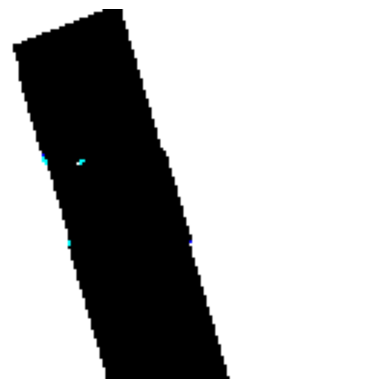

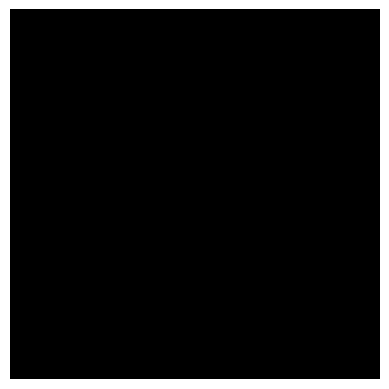

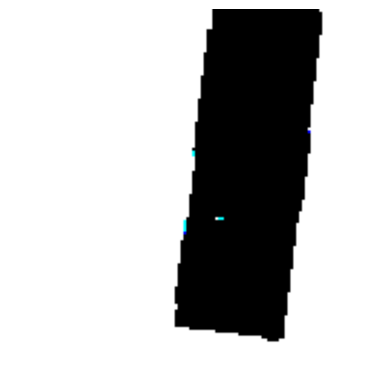

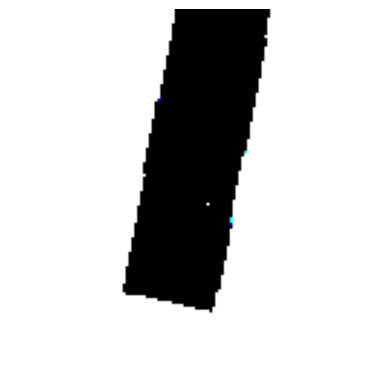

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Enhanced Data Augmentation to improve model generalization
data_gen = ImageDataGenerator(
    rotation_range=20,                # Increase rotation range
    width_shift_range=0.2,            # Increase width shift range
    height_shift_range=0.2,           # Increase height shift range
    zoom_range=0.2,                   # Increase zoom range
    horizontal_flip=True,
    vertical_flip=True,              # Add vertical flipping
    shear_range=0.2,                  # Add shear transformations
    brightness_range=[0.8, 1.2],     # Random brightness adjustment
    fill_mode='nearest'
)

# Sample augmented images
image_sample = train_df['image_data'].iloc[0].reshape((1, 128, 128, 3))  # Sample image for augmentation
augmented_images = data_gen.flow(image_sample, batch_size=1)

# Plot augmented images
for i in range(5):
    augmented_image = next(augmented_images)[0]
    plt.imshow(augmented_image)
    plt.axis('off')  # Hide axis for better visualization
    plt.show()


In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.optimizers import Adam

def create_cnn_model():
    # Load VGG16 model pre-trained on ImageNet without the top classification layer
    base_model = VGG16(weights='imagenet', include_top=False, input_shape=(128, 128, 3))

    # Freeze base model layers to retain pre-trained features
    for layer in base_model.layers:
        layer.trainable = False

    # Add custom top layers
    x = base_model.output
    x = Flatten()(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.5)(x)
    x = Dense(1, activation='linear')(x)  # Output a numeric value

    model = Model(inputs=base_model.input, outputs=x)
    return model

# Instantiate and compile the updated model
cnn_model = create_cnn_model()
cnn_model.compile(optimizer=Adam(learning_rate=0.0001), loss='mean_squared_error')

# Convert images for CNN training
X_images = np.stack(train_df['image_data'].values)

# Ensure y_values is numeric
y_values = pd.to_numeric(train_df['entity_value'], errors='coerce')

# Check and handle NaNs if necessary
if y_values.isna().any():
    print("Warning: Some values in 'entity_value' could not be converted to numeric.")
    # Optionally handle NaNs here (e.g., impute or remove them)
    y_values = y_values.fillna(0)  # Example: fill NaNs with 0

# Convert to numpy array
y_values = y_values.values

# Train-test split
X_train, X_val, y_train, y_val = train_test_split(X_images, y_values, test_size=0.2, random_state=42)

# Ensure the shapes are correct
print(f"Shape of X_train: {X_train.shape}")
print(f"Shape of y_train: {y_train.shape}")

# Ensure y_train and y_val are float32
y_train = y_train.astype('float32')
y_val = y_val.astype('float32')

# Train the CNN model
# Adjusted training parameters for better performance
cnn_model.fit(
    X_train,
    y_train,
    validation_data=(X_val, y_val),
    epochs=20,                    # Increased number of epochs for better convergence
    batch_size=32,                # Adjust batch size if necessary
    callbacks=[
        tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True),  # Early stopping to prevent overfitting
        tf.keras.callbacks.ModelCheckpoint('best_model.h5', save_best_only=True, monitor='val_loss')  # Save the best model
    ]
)



Shape of X_train: (799, 128, 128, 3)
Shape of y_train: (799,)


ValueError: The filepath provided must end in `.keras` (Keras model format). Received: filepath=best_model.h5

In [ ]:
# Use the OCR output for text-based model
def text_based_model(ocr_text):
    # Simple model that analyzes OCR text (could be more sophisticated)
    if 'gram' in ocr_text.lower():
        return 'weight'
    elif 'volt' in ocr_text.lower():
        return 'voltage'
    elif 'watt' in ocr_text.lower():
        return 'wattage'
    # Add more entity handling rules as needed
    return None

# Apply the OCR-based model on the dataset
train_df['predicted_entity'] = train_df['ocr_text'].apply(text_based_model)

# Convert text-based predictions to numerical values for ensemble
def entity_to_numeric(entity):
    # Mapping text-based entities to simple numeric placeholders
    entity_map = {'weight': 1.0, 'voltage': 2.0, 'wattage': 3.0}
    return entity_map.get(entity, 0.0)  # Default to 0 if entity not found

train_df['predicted_entity_numeric'] = train_df['predicted_entity'].apply(entity_to_numeric)

# Ensemble predictions: average CNN model output and OCR predictions
cnn_predictions = cnn_model.predict(X_images).flatten()

# Ensure both columns are numeric before averaging
train_df['ensemble_pred'] = (train_df['predicted_entity_numeric'] + cnn_predictions) / 2


32/32 ━━━━━━━━━━━━━━━━━━━━ 6s 185ms/step


In [ ]:
import numpy as np
import requests
from PIL import Image
from io import BytesIO

def load_image_from_url(image_url, target_size=(128, 128)):
    try:
        response = requests.get(image_url)
        img = Image.open(BytesIO(response.content))
        img = img.convert('RGB')  # Ensure image is RGB
        img = img.resize(target_size)  # Resize images to standard size
        img = np.array(img)
        return img / 255.0  # Normalize image
    except Exception as e:
        print(f"Error loading image from {image_url}: {e}")
        # Return a blank image in case of an error
        return np.zeros((*target_size, 3))

def preprocess_images(image_urls, target_size=(128, 128)):
    images = []
    for url in image_urls:
        img = load_image_from_url(url, target_size)
        if img.shape != (*target_size, 3):
            print(f"Unexpected image shape: {img.shape}")
            img = np.zeros((*target_size, 3))  # Replace with a blank image if shape is incorrect
        images.append(img)
    images_array = np.array(images)
    return images_array

# Example usage for test data
test_image_urls = test_df['image_link'].values  # Assuming image URLs are in 'image_link'
test_images = preprocess_images(test_image_urls)
print(f"Shape of test_images: {test_images.shape}")



Shape of test_images: (999, 128, 128, 3)


In [ ]:
import cv2
import numpy as np

def preprocess_and_stack_images(image_data_list, target_size=(128, 128)):
    """
    Resize and preprocess images to ensure they all have the same shape.

    Args:
        image_data_list (list of numpy arrays): List of image data arrays.
        target_size (tuple): Target size for the images (height, width).

    Returns:
        numpy array: Stacked array of preprocessed images.
    """
    processed_images = []

    for img in image_data_list:
        # Check if img is grayscale (2D) or RGB (3D)
        if img.ndim == 2:  # Grayscale image
            img = np.stack([img] * 3, axis=-1)  # Convert grayscale to RGB
        elif img.ndim == 3 and img.shape[-1] == 4:  # RGBA image
            img = img[..., :3]  # Remove alpha channel
        elif img.ndim != 3 or img.shape[-1] not in [1, 3]:  # Unexpected number of channels
            raise ValueError(f"Unexpected image format. Expected grayscale or RGB with 1 or 3 channels, got {img.ndim}D with shape {img.shape}.")

        # Resize image
        img_resized = cv2.resize(img, target_size[::-1])  # Resize to target size (width, height)

        # Check image has 3 channels
        if img_resized.shape[-1] != 3:
            raise ValueError(f"Unexpected number of channels in resized image. Expected 3, got {img_resized.shape[-1]}.")

        processed_images.append(img_resized)

    return np.array(processed_images)

# Ensure test images have the same shape
test_image_data_list = test_df['image_data'].values
test_images = preprocess_and_stack_images(test_image_data_list)

# Predictions on test data
cnn_predictions = cnn_model.predict(test_images).flatten()

# Ensure y_true and y_pred are numeric and handle NaNs if necessary
y_true = pd.to_numeric(train_df['entity_value'], errors='coerce').fillna(0).values
y_pred = pd.to_numeric(train_df['ensemble_pred'], errors='coerce').fillna(0).values

# Ensure the predictions and true values are compatible for F1 score calculation
# If you are using regression, the F1 score might not be suitable; consider other metrics
if len(y_true) == len(y_pred):
    # For demonstration, using rounded values for binary classification example
    f1 = f1_score(y_true.round(), y_pred.round(), average='macro')
    print(f'Final F1 Score: {f1}')
else:
    print('Mismatch in length of true values and predictions.')


32/32 ━━━━━━━━━━━━━━━━━━━━ 7s 204ms/step
Final F1 Score: 0.495199595755432
